In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [12]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"

all_TPR = {}
all_SIC = {}
all_FPR = {}
all_ROC = {}

In [ ]:
num_bins_SR = 16 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "septic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [14]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

# Load in the original data

In [15]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [16]:
# if train_samesign = False, this loads in the OS test data
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot histograms for a small number of FPR thresholds

In [17]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [18]:
def plot_upsilon_resonances(ax):

    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [25]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        if ONE_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
            q0 = test_statistic(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov = pcov, ONE_SIDED = ONE_SIDED)

            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

            print(f"Significance: {significance}", "sqrt(q0):", np.sqrt(q0), "ratio:", np.sqrt(q0)/significance)

        elif TWO_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR, chi2 = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov = pcov, ONE_SIDED = False, TWO_SIDED = TWO_SIDED)


            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = chi2
            print(f"Significance: {significance}")


        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    


<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:78: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1541489/3996227022.py:62: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))
/tmp/ipykernel_1541489/3996227022.py:78: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


(11, 6) (6, 6) (11, 11)
(11,)
Significance: 0.8689639080130891 sqrt(q0): 1.8516312861158821 ratio: 2.13084947377123
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 5.383199275387779 sqrt(q0): 11.534722989431913 ratio: 2.142726360171946
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 6.557547898325821 sqrt(q0): 13.613083807636283 ratio: 2.0759411930657463
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 10.648206751817943 sqrt(q0): 24.015700973562105 ratio: 2.2553751568978466
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 13.144920301219214 sqrt(q0): 25.011782595457507 ratio: 1.9027717188317697
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 9.574150674609538 sqrt(q0): 21.74765724363001 ratio: 2.2714972829187214
(11, 6) (6, 6) (11, 11)
(11,)
Significance: 6.9181009190261396 sqrt(q0): 14.662729715647965 ratio: 2.1194732322164556


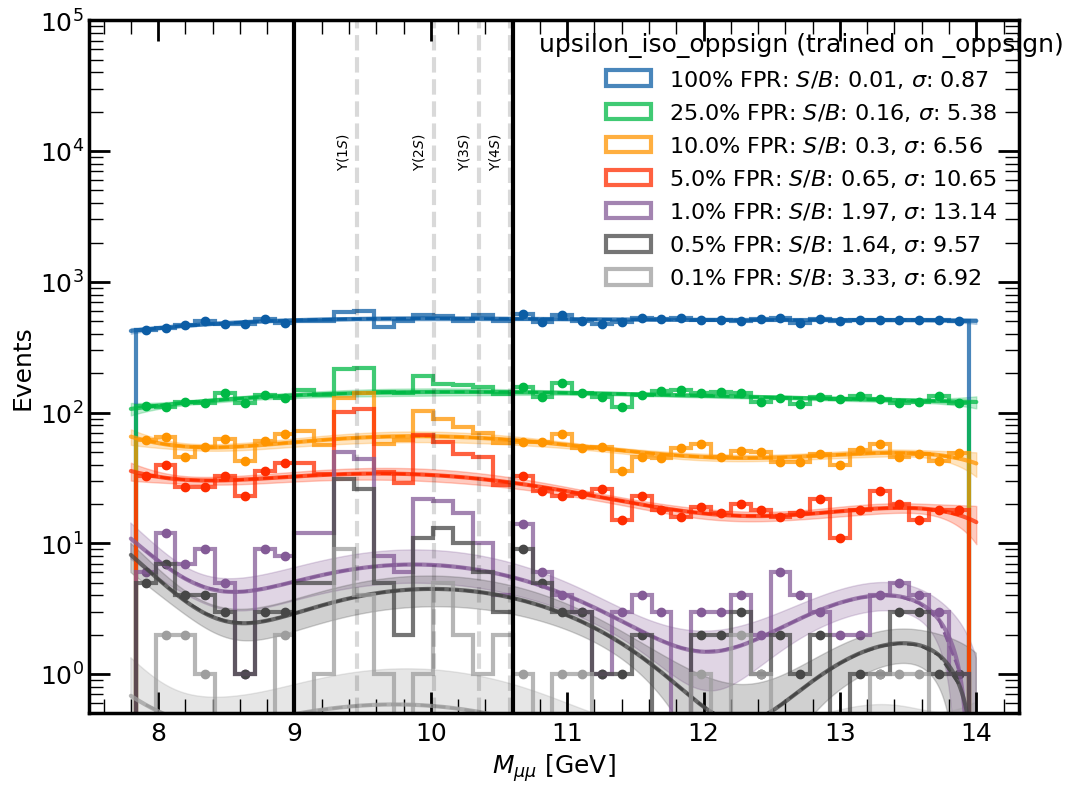

In [26]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


/tmp/ipykernel_1541489/522435372.py:62: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))
/tmp/ipykernel_1541489/522435372.py:78: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:376: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,4))+", $S/\sqrt{B}$: "+str(round(significance,4))
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:388: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)


NameError: name 'q0' is not defined

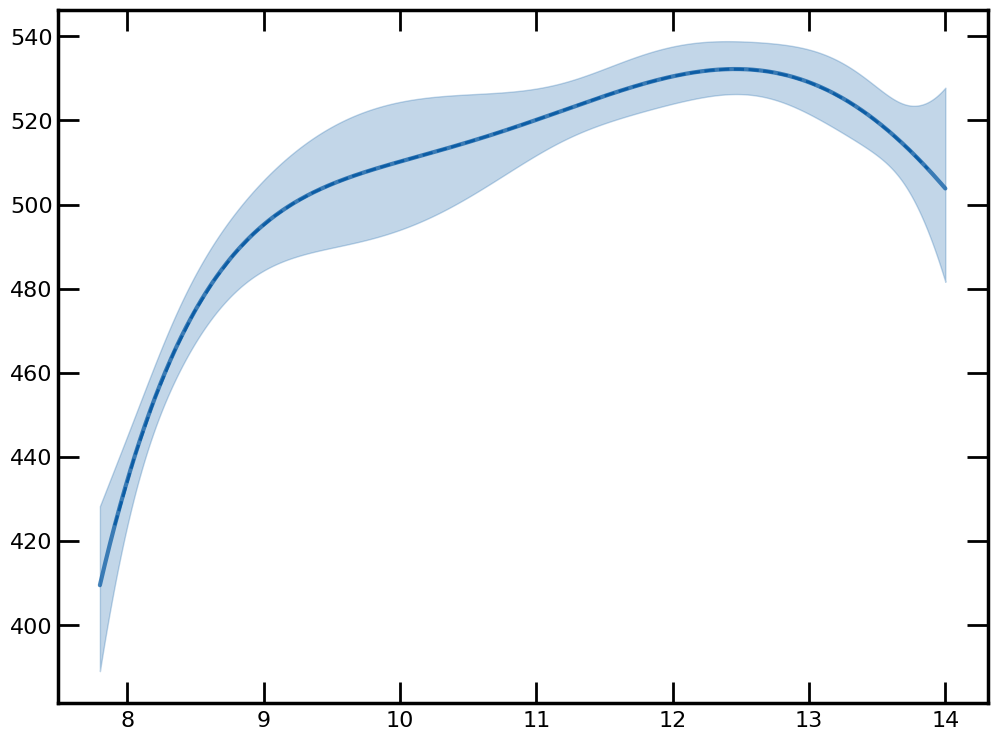

In [22]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)





In [ ]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


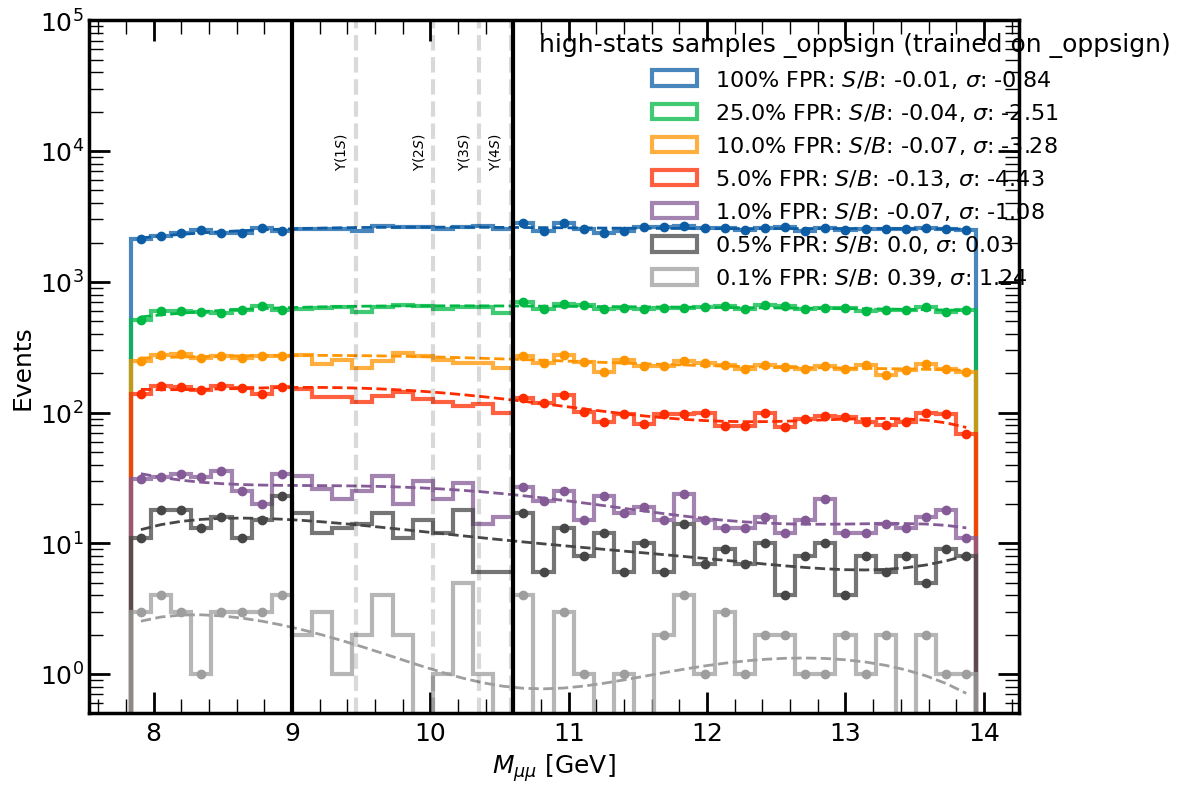

In [ ]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [ ]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

        

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
                # calculate significance of bump
        if ONE_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)


            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

            
        elif TWO_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR, signif = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov = pcov, ONE_SIDED = False, TWO_SIDED = TWO_SIDED)
            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = signif

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))


        hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
        # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")




    legend_title = rf"Upsilon {feature}: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    



<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:143: SyntaxWarning: invalid escape sequence '\m'
<>:126: SyntaxWarning: invalid escape sequence '\s'
<>:143: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1476937/450196315.py:126: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))
/tmp/ipykernel_1476937/450196315.py:143: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


dimu_pt
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
mu0_ip3d
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
mu1_ip3d
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


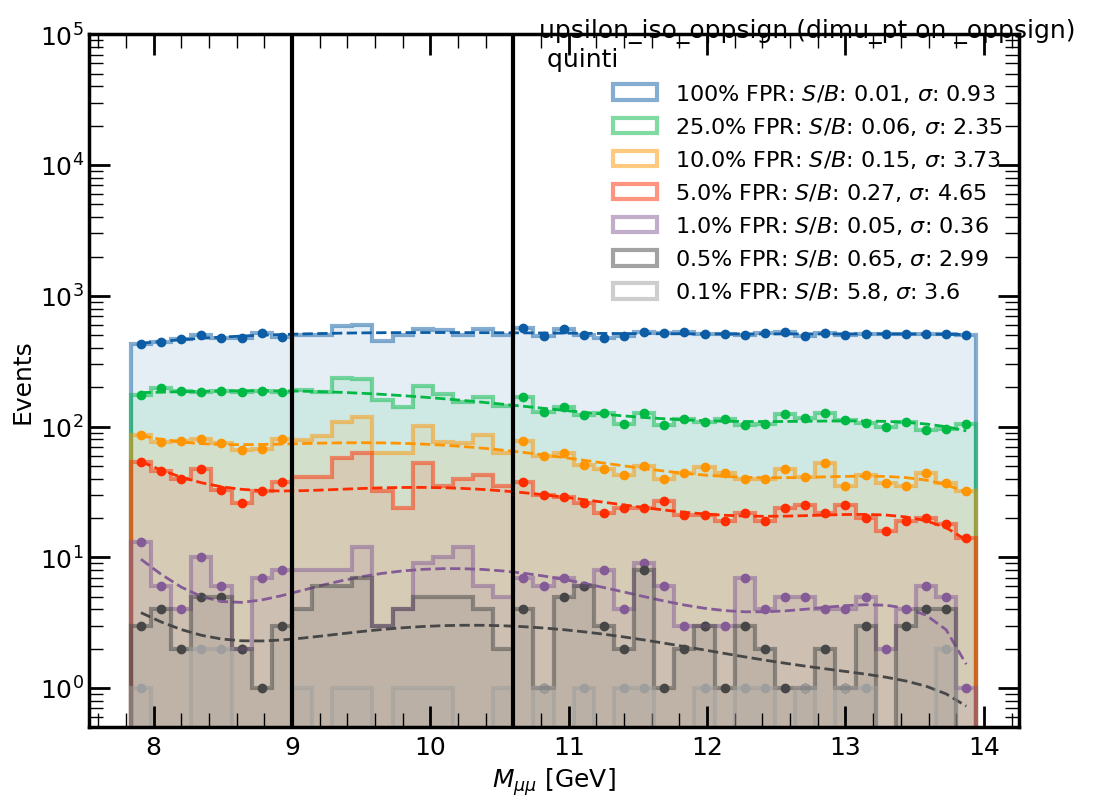

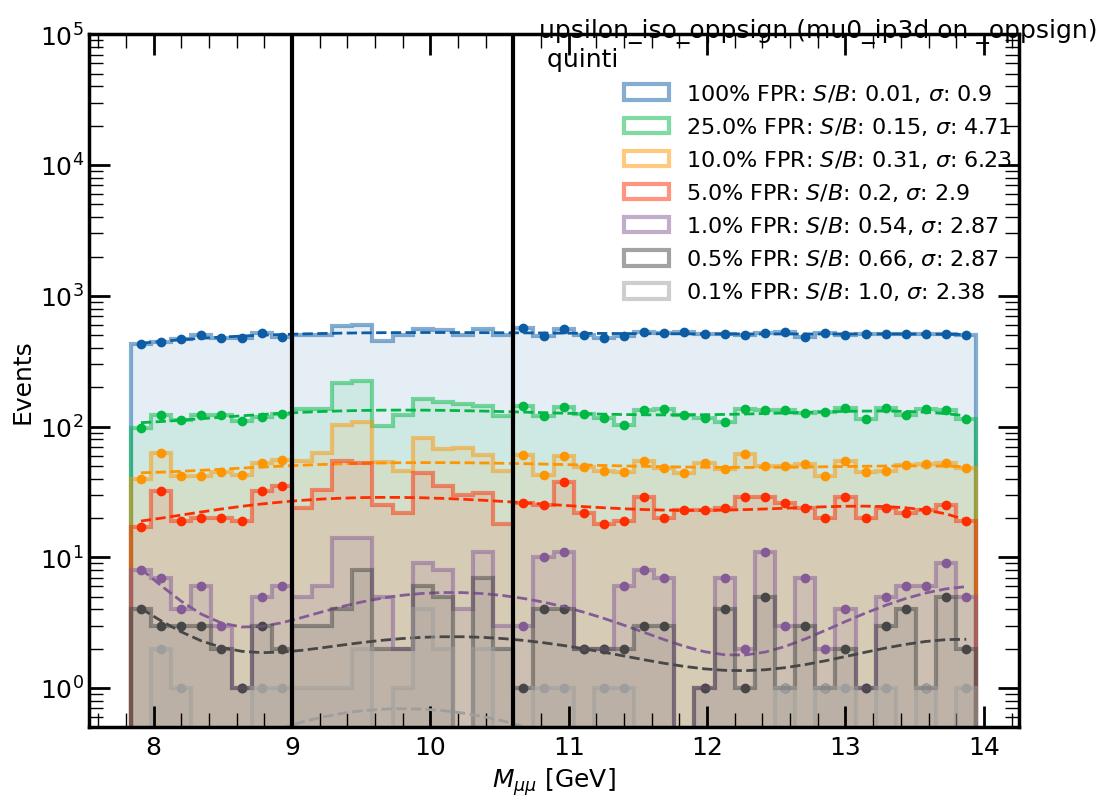

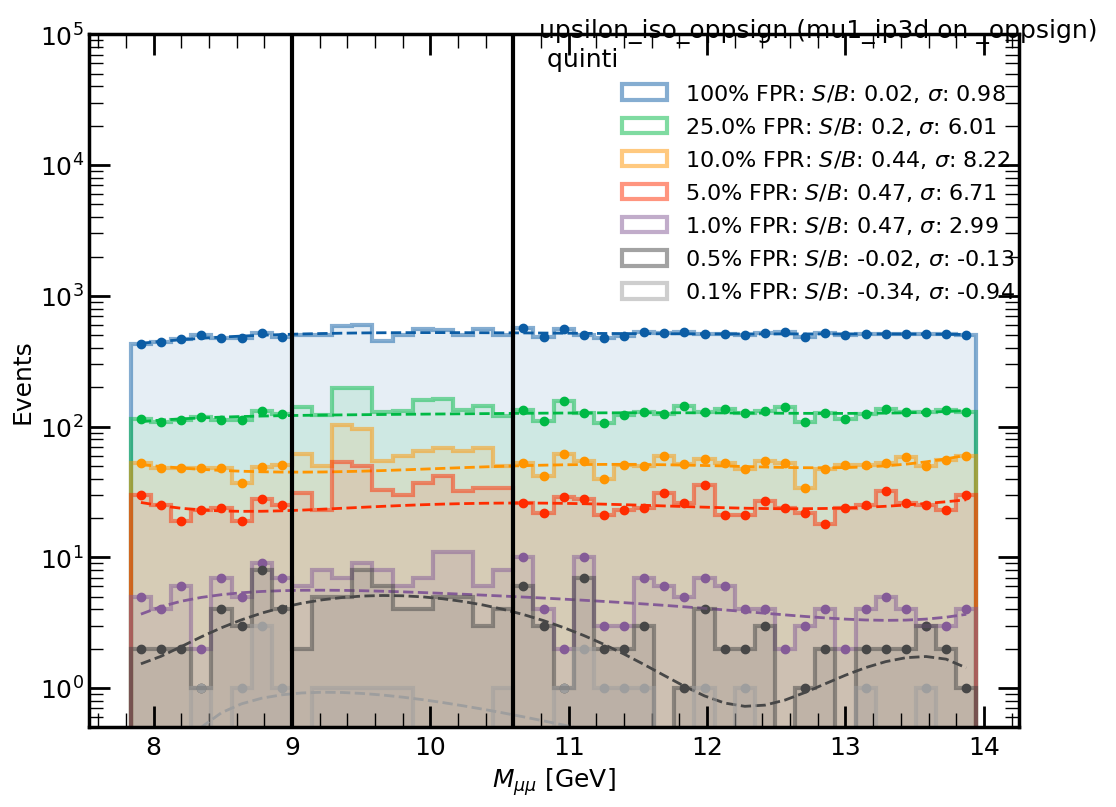

In [ ]:
flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    fpr_results_quintic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, "quintic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])



In [ ]:
# Plot ROC

In [ ]:
fit_type = "quintic"
fit_function = bkg_fit_quintic

In [ ]:
# """
# CALCULATE THE ROC CURVES
# """

# # determine fpr thresholds as before
# # yes this is repeated code
# fpr_thresholds_finegrained = np.logspace(0, -3, 20)
# #fpr_thresholds = np.linspace(1, 0 , 50)

# plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# # first determine score cutoffs
# score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

# for pseudo_e in range(num_pseudoexperiments):
#     for i_fold in range(n_folds):
#         loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
#         for threshold in fpr_thresholds_finegrained:
#             loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
#             score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
# def get_classifier_metrics_high_stats(dataset_id, score_cutoffs):
            
#     S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

#     for pseudo_e in range(num_pseudoexperiments):

#         print(f"On pseudo experiment {pseudo_e+1}...")
#         for t, threshold in enumerate(fpr_thresholds_finegrained):

#             filtered_masses_bs = []

#             for i_fold in range(n_folds):
#                 loc_true_masses_bs = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e][dataset_id][i_fold][:,-1]).reshape(-1,1))
#                 loc_scores_bs = all_alt_scores_splits[pseudo_e][dataset_id][i_fold]
#                 # filter top event based on score cutoff
#                 loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
#                 filtered_masses_bs.append(loc_filtered_masses_bs)

#             filtered_masses_bs = np.concatenate(filtered_masses_bs)
#             # get the fit function to SB background
#             popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
#             num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
        
#             S_yield[t, pseudo_e] = num_S_expected_in_SR
#             B_yield[t, pseudo_e] = num_B_expected_in_SR
        
#     # calculate summary stats
#     TPR = S_yield/S_yield[0,:]
#     FPR = B_yield/B_yield[0,:]
    

#     ROC = 1.0/FPR

#     SIC = TPR/np.sqrt(FPR)
    
#     return TPR, FPR, ROC, SIC


"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))


    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

            # calculate significance of bump
            if ONE_SIDED:
                num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)


                y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
                B_error = np.sqrt(np.sum(y_err**2))
                S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
                significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

                
            elif TWO_SIDED:
                num_S_expected_in_SR, num_B_expected_in_SR, signif = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov = pcov, ONE_SIDED = False, TWO_SIDED = TWO_SIDED)


                y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
                B_error = np.sqrt(np.sum(y_err**2))
                S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

                significances[t, pseudo_e] = signif

            # TODO: ERRORS
            
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)

    if TWO_SIDED:
        SIC = significances / significances[0,:]
    
    return TPR, FPR, ROC, SIC


In [ ]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """





    num_experiments = 100
    fpr_thresholds = np.logspace(-4, 0, 25)[::-1]
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SR_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SBH_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    for e in range(num_experiments):

        # Resample the masses
        # print(mass_SBL_cut_0.shape)
        mass_SBL = np.random.choice(mass_SBL_0, size =  len(mass_SBL_0), replace = True)
        mass_SBH = np.random.choice(mass_SBH_0, size =  len(mass_SBH_0), replace = True)
        mass_SR = np.random.choice(mass_SR_0, size =  len(mass_SR_0), replace = True)

        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]



            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background
            # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            #print("chi2/dof:", chi2/n_dof)
            

            # calculate significance of bump
            if ONE_SIDED:
                num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)


                y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
                B_error = np.sqrt(np.sum(y_err**2))
                S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
                significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

                
            elif TWO_SIDED:
                num_S_expected_in_SR, num_B_expected_in_SR, signif = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov = pcov, ONE_SIDED = False, TWO_SIDED = TWO_SIDED)

                y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
                B_error = np.sqrt(np.sum(y_err**2))
                S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

                significances[t, e] = signif
                # print(f"Significance: {significances[t, e]}")

            # TODO: ERRORS
            
            S_yield[t, e] = num_S_expected_in_SR
            B_yield[t, e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = np.nan_to_num(S_yield/S_yield[0,:])
    FPR = np.nan_to_num(B_yield/B_yield[0,:])
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)

    if TWO_SIDED:
        SIC = np.nan_to_num(significances / significances[0,:])
    
    return TPR, FPR, ROC, SIC, significances


In [ ]:
TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)


On pseudo experiment 1...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 2...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 4...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 5...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6)

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 6...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 7...


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 8...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 9...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6)

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 11...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 12...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 15...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 16...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 17...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 23...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 24...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 29...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 30...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 33...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 34...


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 35...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 36...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 37...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 39...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 44...
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 45...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 46...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 47...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 49...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 51...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 52...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 55...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 57...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 58...


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 59...
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_1476937/3532041755.py:116: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)


/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_e

(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 60...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 61...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 62...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_1476937/3532041755.py:117: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
On pseudo experiment 64...
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6) (11, 11)
(11,)
(11, 6) (6, 6

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:376: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,4))+", $S/\sqrt{B}$: "+str(round(significance,4))
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:388: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)


KeyboardInterrupt: 

dimu_pt


/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:154: RuntimeWarning: overflow encountered in divide
  ROC = 1.0/FPR
/tmp/ipykernel_834690/3392942024.py:156: RuntimeWarning: invalid value encountered in sqrt
  SIC = TPR/np.sqrt(FPR)


mu0_ip3d


/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_o

mu1_ip3d


/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_834690/3392942024.py:139: RuntimeWarning: overflow encountered in scalar divide
  S_o

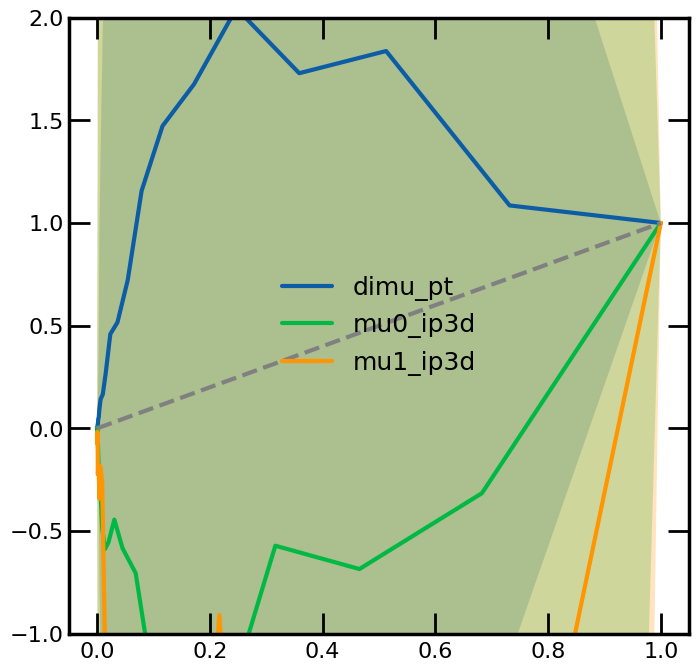

In [ ]:



feature_TPRs = {}
feature_FPRs = {}
feature_ROCs = {}
feature_SICs = {}
feature_SIGs = {}

flip_features = [False, True, True] 
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_TPRs[feature], feature_FPRs[feature], feature_ROCs[feature], feature_SICs[feature], feature_SIGs[feature] = feature_cut_ROCS(feature, test_data_dict, scaler, "quintic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i)
    plt.plot(feature_FPRs[feature].mean(axis = 1), feature_TPRs[feature].mean(axis = 1), label = feature)

    # band 
    feature_TPRS_mean = feature_TPRs[feature].mean(axis = 1)
    feature_TPRS_std = feature_TPRs[feature].std(axis = 1)

    feature_FPRS_mean = feature_FPRs[feature].mean(axis = 1)
    feature_FPRS_std = feature_FPRs[feature].std(axis = 1)

    plt.fill_between(feature_FPRS_mean, feature_TPRS_mean-feature_TPRS_std, feature_TPRS_mean+feature_TPRS_std, alpha = 0.25)

plt.ylim(-1, 2)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "grey")

plt.legend()



[1.00000000e+00 6.82340176e-01 4.63699401e-01 3.13794893e-01
 2.16768377e-01 1.47466216e-01 9.97828965e-02 6.59794174e-02
 4.41222516e-02 3.13805008e-02 2.14855325e-02 1.38298939e-02
 8.87300689e-03 5.56684622e-03 3.94952772e-03 2.54513793e-03
 1.70898643e-03 1.21945491e-03 7.54782349e-04 4.62232382e-04
 4.62232382e-04 1.84466550e-04 1.34811305e-04 1.34811305e-04
 3.36349786e-05]
[1.0, -3.175689602345669, -4.9659317969358385, -5.177447634341792, -0.9093629569728621, -3.493604744333122, -3.2445857664516358, -4.075328224152182, -3.8745476898377404, -1.9487733970878833, -1.484961267923348, -1.0615709210754563, -0.26210384553936883, -0.18511544063843435, -0.3428285006507008, -0.18269040378940735, -0.18799895173504486, -0.22410328802987425, -0.040070773238626164, -0.016432321533008467, -0.016432321533008467, -0.07420544386078419, -0.05875819520434538, -0.05875819520434538, -0.04600894414474377]


/tmp/ipykernel_834690/1722980235.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


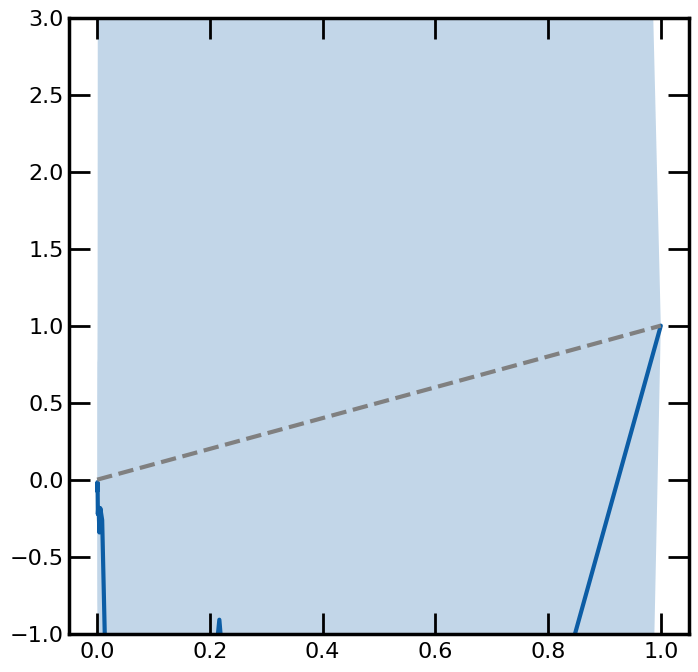

In [ ]:
fpr_means = feature_FPRs[feature].mean(axis = 1)
# Get the list of finite TPRs
tpr_means = []
tpr_stds = []
for i, fpr in enumerate(range(feature_TPRs[feature].shape[0])):

    finite = np.isfinite(feature_TPRs[feature][i,:])
    tpr_means.append(np.nanmean(feature_TPRs[feature][i,:][finite]))
    tpr_stds.append(np.nanstd(feature_TPRs[feature][i,:][finite]))

print(fpr_means)
print(tpr_means)
plt.plot(fpr_means, tpr_means)
plt.fill_between(fpr_means, np.array(tpr_means)-np.array(tpr_stds), np.array(tpr_means)+np.array(tpr_stds), alpha = 0.25)

plt.ylim(-1, 3)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "grey")

plt.legend()

In [ ]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_TPRs["CATHODE"] = TPR
feature_FPRs["CATHODE"] = FPR
feature_ROCs["CATHODE"] = ROC
feature_SICs["CATHODE"] = SIC


In [ ]:
print(feature_SIGs["dimu_pt"])

[[ 2.56465173e+00  2.65385252e+00  5.71013326e+00 ...  3.35580012e+00
   4.82176261e+00  5.63590663e+00]
 [ 2.18088938e+00  3.96039838e+00  5.78046718e+00 ...  3.49822110e+00
   6.99555924e+00  6.64055518e+00]
 [ 4.25170651e+00  4.53881007e+00  7.55444419e+00 ...  5.35354532e+00
   8.27918467e+00  6.27718000e+00]
 ...
 [ 1.97292472e-02  1.06345402e-02  1.15185741e-02 ...  5.75759174e-02
   9.10646415e-03  1.32092754e-02]
 [ 1.86323601e-02  1.21377903e-02  8.50679370e-03 ...  1.18233091e-02
   9.08815427e-03  9.93004228e-03]
 [ 9.75852479e-05 -0.00000000e+00  5.42280910e-08 ...  5.09753993e-04
   6.92938615e-07  1.58240263e-07]]


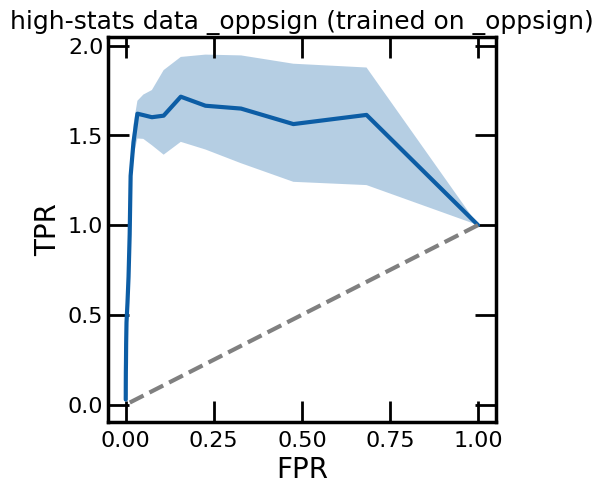

In [ ]:
     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



[1.00000000e+00 7.32333540e-01 5.12094843e-01 3.58030705e-01
 2.47619395e-01 1.72150720e-01 1.15190205e-01 7.87176699e-02
 5.41507861e-02 3.71182998e-02 2.33811408e-02 1.47051365e-02
 9.75181194e-03 6.48336541e-03 3.96507631e-03 2.82477476e-03
 1.91676103e-03 1.26008441e-03 7.46210171e-04 4.03300432e-04
 2.48464501e-04 1.65897538e-04 1.17137377e-04 7.22229175e-05
 1.52698000e-05]
[ 1.00000000e+00  6.83489903e-01  4.75874587e-01  3.27266091e-01
  2.26255804e-01  1.56253027e-01  1.07588877e-01  7.42627429e-02
  4.99476148e-02  3.31323874e-02  2.19787405e-02  1.38531253e-02
  1.11659450e-02  7.93158099e-03  4.92846624e-03  2.13917498e-03
  1.14151283e-03  6.78816407e-04  2.85886476e-04  1.68551672e-04
  9.38581553e-05  6.28579293e-05  4.68486473e-05 -2.09549468e-05
 -5.13922142e-07]


/tmp/ipykernel_834690/3870891090.py:31: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(FPR_median, FPR_median/np.sqrt(FPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")


(0.0, 5.0)

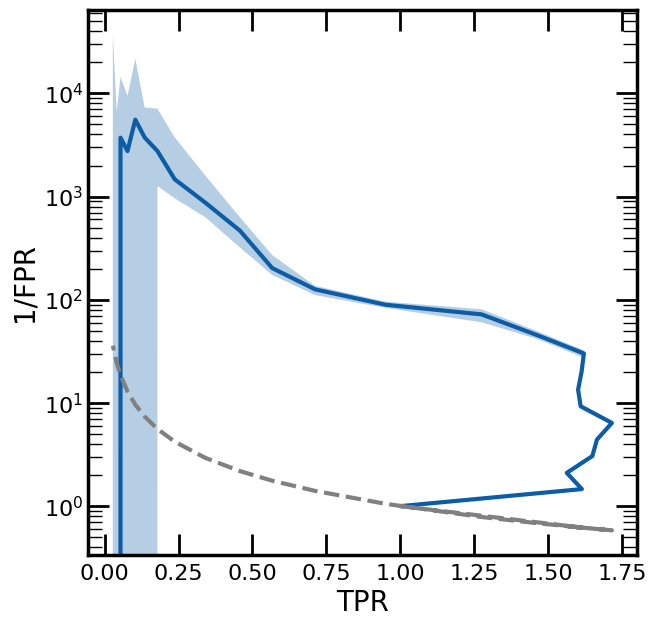

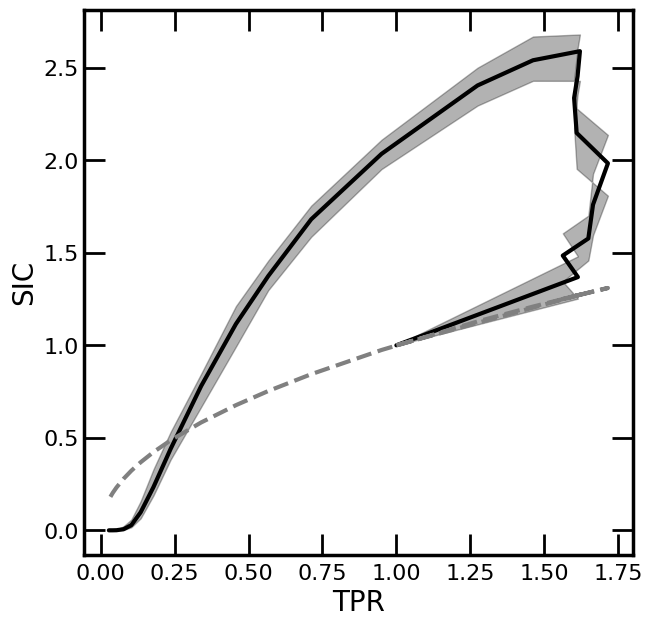

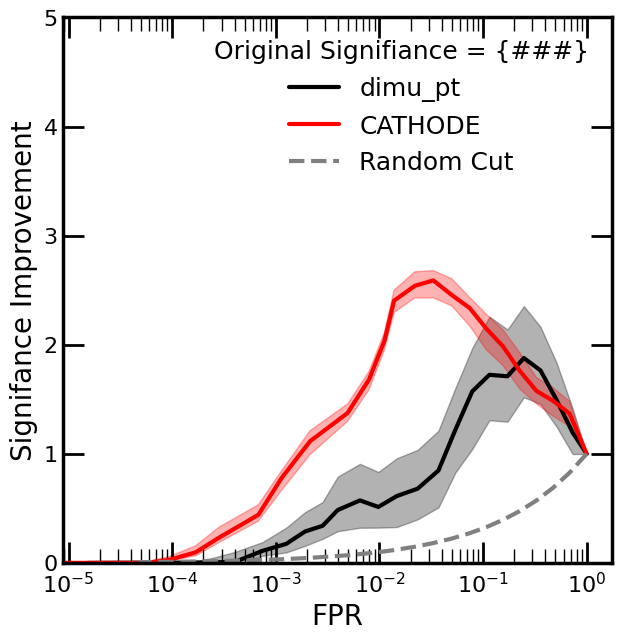

In [ ]:

fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, ROC_median)
ax.fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax.plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("1/FPR")
ax.set_yscale("log")


fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, SIC_median, color = "black")
ax.fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
ax.plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("SIC")

# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["black", "red"]
for (i, key) in enumerate(["dimu_pt", "CATHODE"]):

    TPR_median, TPR_lower, TPR_upper = get_median_percentiles(feature_TPRs[key])
    FPR_median, FPR_lower, FPR_upper = get_median_percentiles(feature_FPRs[key])
    ROC_median, ROC_lower, ROC_upper = get_median_percentiles(feature_ROCs[key])
    SIC_median, SIC_lower, SIC_upper = get_median_percentiles(feature_SICs[key])

    print(FPR_median)

    ax.plot(FPR_median, SIC_median, color = colors[i], label = key)
    ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = colors[i])
ax.plot(FPR_median, FPR_median/np.sqrt(FPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Signifance Improvement")

legend_title = "Original Signifiance = {###}"
plt.legend(title = legend_title, loc = "upper right")
plt.xscale("log")
plt.ylim(0, 5)


# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)